In [ ]:
"""
TRY:
1) K-means
2) Mini Batch K-Means
3) DBSCAN: https://github.com/gboeing/urban-data-science/blob/master/15-Spatial-Cluster-Analysis/cluster-analysis.ipynb 
    
"""

In [2]:
import numpy as np
import pandas as pd

import math
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline
import matplotlib.pyplot as plt


os.chdir("/.../")

pd.options.mode.chained_assignment = None  # default='warn'

from tqdm import tnrange, tqdm_notebook

In [3]:
data = {'tra': pd.read_csv('train_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'tes': pd.read_csv('test_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'sub': pd.read_csv('sample.csv')       }

data['tra'] = data['tra'].rename(columns={'pos_adress_lat':'pos_address_lat', 'pos_adress_lon':'pos_address_lon'})

In [4]:
"""убираем транзакции без координат (initial train)"""

data['tra']['address_lat'] = data['tra']['pos_address_lat'].fillna(data['tra']['atm_address_lat'])
data['tra']['address_lon'] = data['tra']['pos_address_lon'].fillna(data['tra']['atm_address_lon'])

data['tra'] = data['tra'][data['tra']['address_lat'].isnull()==0]

data['tra']['gps'] = data['tra']['address_lat'].apply(str) + ', ' + data['tra']['address_lon'].apply(str)

In [5]:
"""убираем транзакции без координат (initial test)"""

data['tes']['address_lat'] = data['tes']['pos_address_lat'].fillna(data['tes']['atm_address_lat'])
data['tes']['address_lon'] = data['tes']['pos_address_lon'].fillna(data['tes']['atm_address_lon'])

data['tes'] = data['tes'][data['tes']['address_lat'].isnull()==0]

data['tes']['gps'] = data['tes']['address_lat'].apply(str) + ', ' + data['tes']['address_lon'].apply(str)

In [5]:
len(data['tra']), len(data['tes'])

(1127294, 1166971)

In [ ]:
"""дубликаты, страна, работа+дом"""

In [6]:
"""убираем id с задвоением дома и работы"""

data['tra']['home_add'] = data['tra'].home_add_lat + ', ' + data['tra'].home_add_lon
data['tra']['work_add'] = data['tra'].work_add_lat + ', ' + data['tra'].work_add_lon

unique_home_add = data['tra'][['customer_id','home_add']].groupby('customer_id')['home_add'].nunique()
unique_work_add = data['tra'][['customer_id','work_add']].groupby('customer_id')['work_add'].nunique()

#len(unique_address.sort_values(ascending=0)[:337]), len(unique_work_add.sort_values(ascending=0)[:48])
print("Кол-во координат уникальных домов: {}".format(data['tra']['home_add'].nunique()), 
      "Кол-во координат уникального места работы: {}".format(data['tra']['work_add'].nunique()))

Кол-во координат уникальных домов: 10146 Кол-во координат уникального места работы: 4584


In [7]:
"""уникальные id, которые имееют 1 дом и 1 работу"""

print("Кол-во id с 1 домом: {}".format(len(unique_home_add[unique_home_add == 1])), 
      "Кол-во id с 1 работой: {}".format(len(unique_work_add[unique_work_add == 1])))

train_ids = list(set(list(unique_home_add[unique_home_add == 1].index)) - 
                 set(list(set(list(unique_home_add[unique_home_add == 1].index)) - 
                          set(list(unique_work_add[unique_work_add == 1].index)))))
#второй вариант расчёта:
#list([x for x in list(unique_work_add[unique_work_add == 1].index) if x in list(unique_home_add[unique_home_add == 1].index)])
print("Кол-во id с 1 домом и 1 работой: {}".format(len(train_ids)))

Кол-во id с 1 домом: 9664 Кол-во id с 1 работой: 5110
Кол-во id с 1 домом и 1 работой: 4860


In [8]:
train_ids = pd.DataFrame(train_ids, columns=['customer_id'])
train_ids['train_ids'] = 1

In [9]:
"""создаем очищенный датасет для обучения"""
train_df = pd.merge(data['tra'], train_ids, on='customer_id', how='left')
train_df = train_df[train_df['train_ids']==1]
train_df.drop('train_ids', axis=1, inplace=True)

"""убираем гр-на с nan в графе место жительства"""
train_df = train_df[train_df.customer_id !='1a7ea74837f017610970ae508dcd0c26']

In [10]:
len(train_df.customer_id.unique())

4859

In [11]:
"""добавляем стоблец 'тип транзакции' в трейн и тест, исправляем ошибку в кодах категории покупок в тесте """
train_df['tr_type'] = np.where(train_df['pos_address_lat'].isnull(), 0, 1)   #atm = 0, pos = 1

test_df = data['tes'].copy()
test_df['tr_type'] = np.where(test_df['pos_address_lat'].isnull(), 0, 1)   #atm = 0, pos = 1
test_df['mcc'] = test_df['mcc'].map(lambda x: str(x).replace(',', ''))

In [12]:
"""убираем ненужные столбцы: atm_address, atm_address_lat, atm_address_lon, 
    city, country, pos_address, pos_address_lat, pos_address_lon """

train_df = train_df.drop(['atm_address', 'atm_address_lat', 'atm_address_lon', 'city', 
                   'country', 'pos_address', 'pos_address_lat', 'pos_address_lon'], axis=1)
test_df = test_df.drop(['atm_address', 'atm_address_lat', 'atm_address_lon', 'city', 
                   'country', 'pos_address', 'pos_address_lat', 'pos_address_lon'], axis=1)

In [13]:
test_df.head(3)

,amount,currency,customer_id,mcc,terminal_id,transaction_date,address_lat,address_lon,gps,tr_type
0,2.2118182443000003,643.0,00fd410f5c580c8351cafa88d82b60f3,5411,ff0476dae4b098a7b16aabe93d4268df,2017-08-24,55.967487399999996,37.9136824,"55.967487399999996, 37.9136824",1
1,1.3313791018,643.0,00fd410f5c580c8351cafa88d82b60f3,4111,7cfd9a60282459d4692ecc85b856072e,2017-08-12,55.9712958,37.9051843,"55.9712958, 37.9051843",1
2,2.6080035353,643.0,00fd410f5c580c8351cafa88d82b60f3,5411,7e5a532f0029861d8a9c4f0479b9450b,2017-06-17,56.016591399999996,37.9090983,"56.016591399999996, 37.9090983",1


In [ ]:
"""объединяем выборки: запоминаем id для востановления"""
"""добавить: обратный гекодинг (подтянуть информацию)"""
"""анализируем получившиеся результаты после объединения"""
"""раставляем одинаковые лейблы в трейне и тесте"""

In [13]:
"""объединяем выборки"""
inf_about_h_and_w_columns = ['home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon', 'home_add', 'work_add']
train_and_test_together = pd.concat([train_df.drop(inf_about_h_and_w_columns, axis=1), test_df])

"""запоминаем id для востановления"""
test_customer_ids = pd.DataFrame(test_df.customer_id.unique(), columns=['customer_id'])
test_customer_ids['test_sample'] = 1

train_customer_ids_w_address = train_df[['customer_id','home_add_lat','home_add_lon', 
                                      'work_add_lat', 'work_add_lon']].drop_duplicates()

train_and_test_together = pd.merge(train_and_test_together, test_customer_ids, on='customer_id', how='left')

In [14]:
len(train_and_test_together)

1713256

In [ ]:
"""!!!!! добавить: обратный гекодинг (подтянуть информацию): два варианта
    1) online: 50% загружено - вернуться позже,
    2) offline: используем """

In [ ]:
reverse_geocoding_first = pd.read_excel(r'reverse geocoding\xlsx\2018_02_18_reverse_geocoding_train_pos.xlsx')
reverse_geocoding_second = pd.read_excel(r'reverse geocoding\xlsx\2018_02_21_rg_third_calc_45520.xlsx')

In [ ]:
print("Первый файл (кол-во координат): {0}, Второй файл: {1} ".format(len(reverse_geocoding_first), 
                                                                      len(reverse_geocoding_second)))
print("Общее количество уникальных координат: {}".format(len(pd.Series(list(reverse_geocoding_first.gps.unique()) + 
                                                                       list(reverse_geocoding_second.gps.unique())).unique())))

In [ ]:
pd.merge(train_and_test_together, reverse_geocoding[['state','pos_lat_lon', 'country']], on=['gps'], how='left')

In [15]:
"""offline подход (быстрый): https://github.com/thampiman/reverse-geocoder """
import reverse_geocoder as rg

train_and_test_together.address_lat = train_and_test_together.address_lat.apply(float)
train_and_test_together.address_lon = train_and_test_together.address_lon.apply(float)

latlon_subset = train_and_test_together[['address_lat', 'address_lon']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]

In [16]:
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

Loading formatted geocoded file...


In [ ]:
"""сохраняем таблицы без дубликатов, admin1 - город"""
reverse_geo_df.drop_duplicates().to_csv(r'C:\Users\drobotov\python\py_boosterspro\Raiffeisen Data Cup\\
data\2018_02_22_reverse_geocoding.csv')
latlon_subset.loc[reverse_geo_df.drop_duplicates().index,:].to_csv(r'C:\Users\drobotov\python\py_boosterspro\\
Raiffeisen Data Cup\\
data\2018_02_22_reverse_geocoding_index_real_latlon.csv')

In [17]:
train_and_test_together['country'] = reverse_geo_df['cc'].values
train_and_test_together['region'] = reverse_geo_df['admin1'].values
train_and_test_together['place'] = reverse_geo_df['name'].values

In [18]:
len(train_and_test_together)

1713256

In [19]:
"""убираем все страны, кроме RU, UA"""
train_and_test_together = train_and_test_together[(train_and_test_together.country == 'RU') |
                                                  (train_and_test_together.country == 'UA')]

In [20]:
"""убираем места, которые встречаются 1 раз"""
places_to_drop = list(train_and_test_together.place.value_counts()[train_and_test_together.place.value_counts() <= 1].index)
train_and_test_together = train_and_test_together[train_and_test_together.place.isin(places_to_drop) == False]

In [21]:
"""форматируем некоторые столбцы"""
train_and_test_together.loc[:,'amount'] = np.array(train_and_test_together['amount'].apply(float))

In [22]:
"""убираем значения amount <= 0"""
train_and_test_together = train_and_test_together[train_and_test_together.amount > 0]

In [23]:
"""создаем переменные с amount"""
train_and_test_together['am_e'] = np.exp(train_and_test_together.amount)
train_and_test_together['am_e2'] = np.exp2(train_and_test_together.amount)

In [24]:
amount_by_id = train_and_test_together.groupby('customer_id').agg(
    {'am_e' : [np.sum, np.mean, np.max, np.min, np.median, np.size, np.std, np.var ]}).reset_index()

amount_by_id.columns = amount_by_id.columns.droplevel()
amount_by_id = amount_by_id.add_prefix('am_')
amount_by_id = amount_by_id.rename(columns={"am_":"customer_id"})

In [25]:
train_and_test_together = pd.merge(train_and_test_together, amount_by_id, on='customer_id', how='left')

In [ ]:
"""!!!!! анализируем получившиеся результаты после объединения (либо после расставления категорий)"""

In [26]:
"""создаем переменные, учитывающие время"""
train_and_test_together['transaction_date'] = pd.to_datetime(train_and_test_together['transaction_date'])

train_and_test_together['month'] = train_and_test_together['transaction_date'].dt.month
train_and_test_together['week'] = train_and_test_together['transaction_date'].dt.week
train_and_test_together['day'] = train_and_test_together['transaction_date'].dt.day
train_and_test_together['dow'] = train_and_test_together['transaction_date'].dt.weekday
train_and_test_together['winm'] = (train_and_test_together.transaction_date.dt.day - 1) // 7 + 1
train_and_test_together['is_wkend'] = np.where((train_and_test_together['dow'] == 5) | 
                                               (train_and_test_together['dow'] == 6), 1, 0)

"""праздники"""

train_and_test_together['23feb'] = np.where(train_and_test_together['transaction_date'] == '2017-02-23', 1, 0) #24.02 - нерабочий
train_and_test_together['8mar'] = np.where(train_and_test_together['transaction_date'] == '2017-03-08', 1, 0)
train_and_test_together['1may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-01', 1, 0)
train_and_test_together['9may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-09', 1, 0) #08.05 - нерабочий
train_and_test_together['12jun'] = np.where(train_and_test_together['transaction_date'] == '2017-06-12', 1, 0)
train_and_test_together['4nov'] = np.where(train_and_test_together['transaction_date'] == '2017-11-06', 1, 0) #04.11 - суббота

"""нерабочие дни"""

train_and_test_together['24feb'] = np.where(train_and_test_together['transaction_date'] == '2017-02-24', 1, 0)
train_and_test_together['8may'] = np.where(train_and_test_together['transaction_date'] == '2017-05-08', 1, 0)

In [26]:
len(train_and_test_together)

1712717

In [28]:
"""загрузка фйла с группировкой"""

most_frq_region_series = pd.read_csv('2018-02-22-id-and-mostfrq-region.csv')
most_frq_region_series = most_frq_region_series.iloc[:,1:]

In [29]:
%%time
"""группировка по id/region (убираем выбросы, связанные с поездками[отпуск, командировки], для каждого id)"""
most_frq_region = {}

for customer in tqdm_notebook(list(train_and_test_together['customer_id'].unique())):
    most_frq_region[customer] = train_and_test_together[train_and_test_together.customer_id
                                                       == customer].region.value_counts().idxmax()

Wall time: 32min 35s


In [32]:
most_frq_region_series = pd.DataFrame(pd.Series(most_frq_region))
most_frq_region_series.index.rename('customer_id', inplace=True)
most_frq_region_series.columns = ['mf_region']
most_frq_region_series.reset_index(inplace=True)

In [34]:
most_frq_region_series.to_csv(r'C:\Users\drobotov\python\py_boosterspro\\
Raiffeisen Data Cup\\
data\2018_02_22_id_and_mostfrq_region.csv')

In [ ]:
# ??? добавляем исключение для Москвы/МО и Санкт-Петербурга/Лен.области (пробуем без него)
#((train_and_test_together.region == 'Москва') + (train_and_test_together.region == 'Московская область') + 
# (train_and_test_together.region == 'Санкт-Петербург') + (train_and_test_together.region == 'Ленинградская область'))

In [29]:
"""фильтрация по самому частому городу для каждого id """

train_and_test_together = pd.merge(train_and_test_together, most_frq_region_series, on='customer_id', how='left')
train_and_test_together = train_and_test_together[train_and_test_together.region == train_and_test_together.mf_region]

In [30]:
"""убираем валюту ОАЭ"""
train_and_test_together = train_and_test_together[train_and_test_together.currency != "784.0"]

In [31]:
len(train_and_test_together)

1360480

In [32]:
"""создаем таблицу вида id/unique gps(latlon), считаем количество повторов; 
    оптимизируем следующий этап вычисления накопленного расстояния"""
cust_and_gps_df = pd.DataFrame(train_and_test_together.groupby(
    ['customer_id', 'gps'])['amount'].count()).reset_index().rename(columns={"amount":"id_gps_count"})
cust_and_gps_df['address_lat'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[0]).apply(float)
cust_and_gps_df['address_lon'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[1]).apply(float)

In [33]:
'''добавляем столбец с каунтом повторяющихся координат'''

train_and_test_together = pd.merge(train_and_test_together, cust_and_gps_df[['customer_id', 'gps', 'id_gps_count']], 
                                   on=['customer_id', 'gps'], how='left')

In [34]:
cum_distance_df01 = pd.read_csv('cum_distance_df_4673.csv',
                                dtype={'cum_distance_and_count':str})
cum_distance_df02 = pd.read_csv('cum_distance_df_4673-10183.csv', 
                                dtype={'cum_distance_and_count':str})
cum_distance = cum_distance_df01.copy()
cum_distance.cum_distance_and_count = cum_distance.cum_distance_and_count.fillna(cum_distance_df02.cum_distance_and_count)
cum_distance = cum_distance[cum_distance.columns[1:]]
cum_distance['cum_neighb_dist'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                          str(x).split(",")[0]).map(lambda
                                                                                                    x: str(x).replace("[", ""))
cum_distance['neighb_count'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                       str(x).split(",")[1]).map(lambda x:
                                                                                                 str(x).replace("]", ""))
train_and_test_together = pd.merge(train_and_test_together, 
                                   cum_distance[['customer_id', 'gps', 'cum_neighb_dist', 'neighb_count']],
                                   on=['customer_id', 'gps'], how='left')

In [35]:
train_and_test_together['mcc'] = train_and_test_together.mcc.apply(int)

mcc_codes = pd.read_csv('mcc_codes.csv')
mcc_codes.irs_description = [str(i).lower() for i in mcc_codes.irs_description]
mcc_codes.columns

Index(['mcc', 'edited_description', 'combined_description', 'usda_description',
       'irs_description', 'irs_reportable'],
      dtype='object')

In [36]:
"""объединяем похожие категории"""
import re
unique_mcc = list(mcc_codes.irs_description.unique())
regex=re.compile(".*(car).*")
group_list = [m.group(0) for l in unique_mcc for m in [regex.search(l)] if m]

In [37]:
"""лист, содержащий mcc коды автомобильной тематики"""
drivers_list = ['car rental agencies', 'car rental' ,'car washes', 
                'car and truck dealers (new & used) sales, service, repairs parts and leasing ', 
                'car and truck dealers (used only) sales, service, repairs parts and leasing ',
               'service stations']

In [38]:
train_and_test_together = pd.merge(train_and_test_together, mcc_codes[['mcc', 'irs_description']], on='mcc', how='left')

In [39]:
drivers_id = list(train_and_test_together[train_and_test_together.irs_description.isin(drivers_list)]['customer_id'].unique())
drivers_id = pd.Series(drivers_id).rename("customer_id")
drivers_id = pd.DataFrame(drivers_id)
drivers_id['is_dr'] = 1
train_and_test_together['is_dr'] = pd.merge(train_and_test_together, drivers_id, on='customer_id', how='left')['is_dr'].fillna(0)

In [40]:
train_and_test_together['address_lat'] = train_and_test_together['address_lat'].apply(float)
train_and_test_together['address_lon'] = train_and_test_together['address_lon'].apply(float)

train_and_test_together['neighb_count'] = train_and_test_together['neighb_count'].apply(float)
train_and_test_together['cum_neighb_dist'] = train_and_test_together['cum_neighb_dist'].apply(float)

In [41]:
train_and_test_together['ttl_count'] = train_and_test_together['neighb_count'] + train_and_test_together['id_gps_count']
train_and_test_together['latlon_sum'] = train_and_test_together['address_lat'] + train_and_test_together['address_lon']
train_and_test_together['latlon_mult'] = train_and_test_together['address_lat'] * train_and_test_together['address_lon']

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [316]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 3 kilometers, converted to radians for use by haversine
epsilon = 4 / kms_per_radian

In [272]:
# represent points consistently as (lat, lon)
#coords = train_and_test_together[train_and_test_together.customer_id 
#                        == idn][['latlon_mult', 'ttl_count']].as_matrix()

In [352]:
# represent points consistently as (lat, lon)
idn = '038b1ed23cb05f73e54c497002dac12e'
coords = train_and_test_together[train_and_test_together.customer_id 
                        == idn][['address_lat', 'address_lon']].as_matrix()

In [353]:
%%time

if len(coords) <= 15:
    min_sample = 2
else:
    min_sample = round(len(coords)/10,0)

db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

Wall time: 12 ms


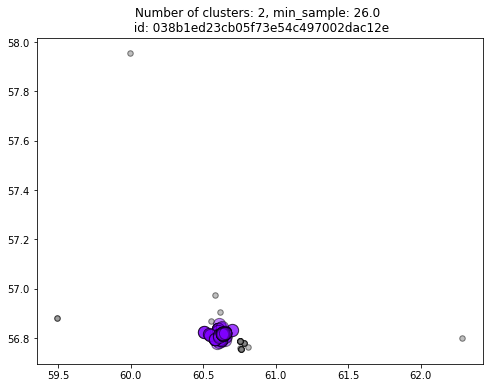

In [354]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 150
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Number of clusters: {0}, min_sample: {2} \n id: {1}'.format(num_clusters, idn, db.min_samples))
plt.show()

In [339]:
coords

array([[ 55.7227343 ,  37.78955709],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.68371935,  37.86587855],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6887993 ,  37.85197088],
       [ 55.7252676 ,  37.6525705 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6839609 ,  37.86172544],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.7081875 ,  37.7453741 ],
       [ 55.6866406 ,  37.8504745 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.681962  ,  37.8645754 ],
       [ 55.6853944 ,  37.85854926],
       [ 55.68408425,  37.8649586 ],
       [ 55.6828294 ,  37.8656603 ],
       [ 55.6828294 ,  37.8656603 ],
 

In [275]:
kmeans = KMeans(n_clusters=4, random_state=17).fit(coords)

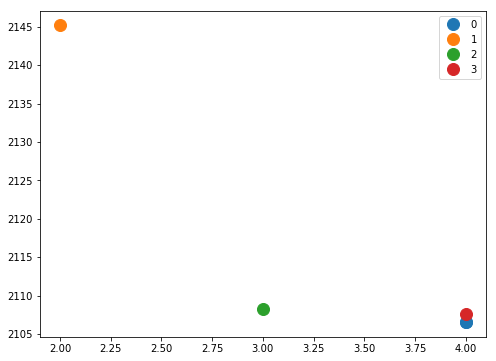

In [276]:
y, x = coords[:,0], coords[:,1]
labels = kmeans.labels_
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [31]:
"""создаем таблицу вида id/unique gps(latlon), считаем количество повторов; 
    оптимизируем следующий этап вычисления накопленного расстояния"""
cust_and_gps_df = pd.DataFrame(train_and_test_together.groupby(
    ['customer_id', 'gps'])['amount'].count()).reset_index().rename(columns={"amount":"id_gps_count"})
cust_and_gps_df['address_lat'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[0]).apply(float)
cust_and_gps_df['address_lon'] = cust_and_gps_df.gps.map(lambda x: str(x).split(',')[1]).apply(float)

In [ ]:
"""
    1) 4673 ids 
    2) 4673-10183
    
pd.Series(cum_distance_list).to_csv(r'C:\Users\User\python\boosterspro\data\cum_distance_list_4673-10183.csv')
cum_distance_series = pd.Series(cum_distance_list)
cum_distance_series.rename("cum_distance_and_count", inplace=True)
cust_and_gps_df.join(cum_distance_series).to_csv(r'C:\Users\User\python\boosterspro\data\cum_distance_df_4673-10183.csv')

    """

In [37]:
%%time
"""считаем дистанцию только для точек, которые попадают в радиус 0.02 градуса"""
cum_distance_list = {}
RADIUS = 0.02

"""берем уникального клиента"""
for cust in tqdm_notebook(list(cust_and_gps_df.customer_id.unique())[4673:]):

    """отсчитываем кол-во шагов (длина массива)"""
    for steps in list(cust_and_gps_df[cust_and_gps_df.customer_id == cust].index):
        
        distance_value = 0
        lat = cust_and_gps_df[cust_and_gps_df.customer_id == cust].loc[steps, 'address_lat']
        lon = cust_and_gps_df[cust_and_gps_df.customer_id == cust].loc[steps, 'address_lon']
        
        df_to_iterate = cust_and_gps_df[(cust_and_gps_df.customer_id == str(cust)) 
                        & ((lat + RADIUS) >= (cust_and_gps_df.address_lat))
                        & ((lat - RADIUS) <= (cust_and_gps_df.address_lat))
                        & ((lon + RADIUS) >= (cust_and_gps_df.address_lon))
                        & ((lon - RADIUS) <= (cust_and_gps_df.address_lon))].copy()
        
        if len(df_to_iterate) == 1:
            cum_distance_list[steps] = [0, 1]
        
        else:
            for tr in list(df_to_iterate.index):
                    
                    x = haversine_fast(lat, 
                                       lon,
                                       df_to_iterate.loc[tr, 'address_lat'],
                                       df_to_iterate.loc[tr, 'address_lon'])
                    
                    distance_value = distance_value + x
                    cum_distance_list[steps] = [distance_value, len(df_to_iterate)]


Wall time: 20h 33min 44s


In [120]:
'''добавляем столбец с каунтом повторяющихся координат'''

train_and_test_together = pd.merge(train_and_test_together, cust_and_gps_df[['customer_id', 'gps', 'id_gps_count']], 
                                   on=['customer_id', 'gps'], how='left')

In [33]:
cum_distance_df01 = pd.read_csv(r'cum distance\cum_distance_df_4673.csv',
                                dtype={'cum_distance_and_count':str})
cum_distance_df02 = pd.read_csv(r'cum distance\cum_distance_df_4673-10183.csv', 
                                dtype={'cum_distance_and_count':str})

In [34]:
cum_distance = cum_distance_df01.copy()
cum_distance.cum_distance_and_count = cum_distance.cum_distance_and_count.fillna(cum_distance_df02.cum_distance_and_count)
cum_distance = cum_distance[cum_distance.columns[1:]]

In [35]:
cum_distance['cum_neighb_dist'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                          str(x).split(",")[0]).map(lambda
                                                                                                    x: str(x).replace("[", ""))
cum_distance['neighb_count'] = cum_distance.cum_distance_and_count.map(lambda x:
                                                                       str(x).split(",")[1]).map(lambda x:
                                                                                                 str(x).replace("]", ""))

In [121]:
train_and_test_together = pd.merge(train_and_test_together, 
                                   cum_distance[['customer_id', 'gps', 'cum_neighb_dist', 'neighb_count']],
                                   on=['customer_id', 'gps'], how='left')

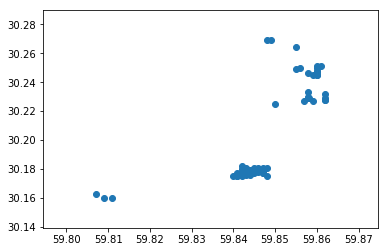

In [41]:
plt.scatter(train_and_test_together[train_and_test_together.customer_id=='0dc0137d280a2a82d2dc89282450ff1b']['address_lat'], 
           train_and_test_together[train_and_test_together.customer_id=='0dc0137d280a2a82d2dc89282450ff1b']['address_lon']);

In [122]:
train_and_test_together['mcc'] = train_and_test_together.mcc.apply(int)

mcc_codes = pd.read_csv('mcc_codes.csv')
mcc_codes.irs_description = [str(i).lower() for i in mcc_codes.irs_description]
mcc_codes.columns

Index(['mcc', 'edited_description', 'combined_description', 'usda_description',
       'irs_description', 'irs_reportable'],
      dtype='object')

In [123]:
"""объединяем похожие категории"""
import re
unique_mcc = list(mcc_codes.irs_description.unique())
regex=re.compile(".*(car).*")
group_list = [m.group(0) for l in unique_mcc for m in [regex.search(l)] if m]

In [124]:
"""лист, содержащий mcc коды автомобильной тематики"""
drivers_list = ['car rental agencies', 'car rental' ,'car washes', 
                'car and truck dealers (new & used) sales, service, repairs parts and leasing ', 
                'car and truck dealers (used only) sales, service, repairs parts and leasing ']

In [125]:
train_and_test_together = pd.merge(train_and_test_together, mcc_codes[['mcc', 'irs_description']], on='mcc', how='left')

In [126]:
drivers_id = list(train_and_test_together[train_and_test_together.irs_description.isin(drivers_list)]['customer_id'].unique())

In [127]:
drivers_id = pd.Series(drivers_id).rename("customer_id")
drivers_id = pd.DataFrame(drivers_id)
drivers_id['is_dr'] = 1

In [128]:
train_and_test_together['is_dr'] = pd.merge(train_and_test_together, drivers_id, on='customer_id', how='left')['is_dr'].fillna(0)

In [72]:
train_and_test_together.columns

Index(['amount', 'currency', 'customer_id', 'mcc', 'terminal_id',
       'transaction_date', 'address_lat', 'address_lon', 'gps', 'tr_type',
       'test_sample', 'country', 'region', 'place', 'am_e', 'am_e2', 'am_sum',
       'am_mean', 'am_amax', 'am_amin', 'am_median', 'am_size', 'am_std',
       'am_var', 'month', 'week', 'day', 'dow', 'winm', 'is_wkend', '23feb',
       '8mar', '1may', '9may', '12jun', '4nov', '24feb', '8may', 'mf_region',
       'id_gps_count', 'cum_neighb_dist', 'neighb_count', 'irs_description',
       'is_dr'],
      dtype='object')

In [ ]:
"""выбираем подход для категориальных переменных: OHE, hashing trick, sparse matrix, pd.get_dummies"""

In [102]:
from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix, hstack

def sparse_dummies(categorical_values):
    categories = Categorical(categorical_values)
    N = len(categorical_values)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix( (ones, (row_numbers, categories.codes)) )

In [143]:
spr_mtx = hstack((sparse_dummies(train_and_test_together.region), 
              sparse_dummies(train_and_test_together.place), 
              sparse_dummies(train_and_test_together.currency),
              sparse_dummies(train_and_test_together.month),
              sparse_dummies(train_and_test_together.irs_description)), 
             format="csr")

In [166]:
spr_mtx.todense

<bound method spmatrix.todense of <1360480x2005 sparse matrix of type '<class 'numpy.float64'>'
	with 6802400 stored elements in Compressed Sparse Row format>>

In [140]:
spr_mtx = spr_mtx.todense

In [142]:
print(spr_mtx)

<bound method spmatrix.todense of <1360480x2005 sparse matrix of type '<class 'numpy.float64'>'
	with 6802400 stored elements in Compressed Sparse Row format>>


In [86]:
"""разряженная матрица для категорийных переменных: region, place, currency, month, irs_description... week, winm"""

train_and_test_together['sparse_mtx'] = hstack((sparse_dummies(train_and_test_together.region), 
              sparse_dummies(train_and_test_together.place), 
              sparse_dummies(train_and_test_together.currency),
              sparse_dummies(train_and_test_together.month),
              sparse_dummies(train_and_test_together.irs_description)), 
             format="csr")

In [71]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train_and_test_together.month)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[ 6  9  9 ..., 10  2  9]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


In [70]:
"""формат float"""

train_and_test_together['cum_neighb_dist'] = train_and_test_together['cum_neighb_dist'].astype(float)
train_and_test_together['neighb_count'] = train_and_test_together['neighb_count'].astype(float)

In [73]:
train_and_test_together = pd.get_dummies(train_and_test_together, columns=["currency", 'month', 'irs_description',
                                                                          'place', 'region'], drop_first=True)

In [74]:
train_and_test_together.shape

(1360480, 2039)

In [75]:
"""раставляем одинаковые лейблы в трейне и тесте"""
lbl = LabelEncoder()
#train_and_test_together['currency'] = lbl.fit_transform(train_and_test_together['currency'])  ##две транзакции ОАЭ
#train_and_test_together['irs_description'] = lbl.fit_transform(train_and_test_together['irs_description'])
#train_and_test_together['place'] = lbl.fit_transform(train_and_test_together['place'])
#train_and_test_together['region'] = lbl.fit_transform(train_and_test_together['region'])
train_and_test_together['country'] = lbl.fit_transform(train_and_test_together['country'])

In [ ]:
"""возвращаем выборку для обчения и для теста (используем дамми-столбец)"""

In [ ]:
"""изменить train > train_df"""

In [76]:
train_df = train_and_test_together[train_and_test_together.test_sample != 1]
test = train_and_test_together[train_and_test_together.test_sample == 1]

print("train_df: {0}, \ntest: {1} ".format(len(train_df), len(test)))

train_df: 435812, 
test: 924668 


In [78]:
"""проверяем, какое минимальное кол-во транзакций для 1 id в трейне,
   сколько уникальных id попало в тестовую выборку (из 9997) """

print("мин. кол-во транзакций для 1 id в train_df: {0}, \nкол-во уник. id  в test: {1} ".format(
    min(train_df.customer_id.value_counts()), 
    test.customer_id.nunique()))

мин. кол-во транзакций для 1 id в train_df: 4, 
кол-во уник. id  в test: 9997 


In [ ]:
"""расчитываем расстояния для цел.переменных (дом, работа)"""
# use train_customer_ids_w_address

In [77]:
train_df = pd.merge(train_df, train_customer_ids_w_address, on='customer_id', how='left')

In [79]:
train_df.columns

Index(['amount', 'customer_id', 'mcc', 'terminal_id', 'transaction_date',
       'address_lat', 'address_lon', 'gps', 'tr_type', 'test_sample',
       ...
       'region_Ulyanovsk', 'region_Vladimir', 'region_Volgograd',
       'region_Vologda', 'region_Voronezj',
       'region_Yamalo-Nenetskiy Avtonomnyy Okrug', 'home_add_lat',
       'home_add_lon', 'work_add_lat', 'work_add_lon'],
      dtype='object', length=2043)

In [80]:
test.columns

Index(['amount', 'customer_id', 'mcc', 'terminal_id', 'transaction_date',
       'address_lat', 'address_lon', 'gps', 'tr_type', 'test_sample',
       ...
       'region_Transbaikal Territory', 'region_Tula', 'region_Tverskaya',
       'region_Udmurtiya', 'region_Ulyanovsk', 'region_Vladimir',
       'region_Volgograd', 'region_Vologda', 'region_Voronezj',
       'region_Yamalo-Nenetskiy Avtonomnyy Okrug'],
      dtype='object', length=2039)

In [81]:
"""переводим координаты во float"""
train_df.address_lat = train_df.address_lat.astype(float)
train_df.address_lon = train_df.address_lon.astype(float)
train_df.home_add_lat = train_df.home_add_lat.astype(float)
train_df.home_add_lon = train_df.home_add_lon.astype(float)
train_df.work_add_lat = train_df.work_add_lat.astype(float)
train_df.work_add_lon = train_df.work_add_lon.astype(float)

In [85]:
"""расстояие от дома до работы: убираем выбросы (?)"""
home_to_work_distance = []

for i, row in tqdm_notebook(enumerate(train_df[['home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']].itertuples())):
    home_to_work_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))
    
train_df['home_to_work_dist'] = np.array(home_to_work_distance)


размер train_df: 435812, с учетом threshold по расстоянию: 389383 (0.89) 


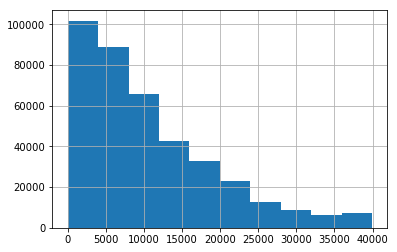

In [86]:
threshold = 40000
train_df[train_df['home_to_work_dist'] < threshold]['home_to_work_dist'].hist();

print("размер train_df: {0}, с учетом threshold по расстоянию: {1} ({2}) ".format(
    len(train_df), 
    len(train_df[train_df['home_to_work_dist'] < threshold]), 
    round((len(train_df[train_df['home_to_work_dist'] < threshold]))/len(train_df),2)))

In [87]:
"""запоминаем новый train"""
train_df = train_df[train_df['home_to_work_dist'] < threshold].copy()

In [88]:
"""растояние до дома: создаем целевую переменную для моделирования / функция для расчета дистанции ниже"""
y_home_distance = []

for i, row in tqdm_notebook(enumerate(train_df[['home_add_lat', 'home_add_lon', 'address_lat', 'address_lon']].itertuples())):
    y_home_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))

In [89]:
"""растояние до работы: создаем целевую переменную для моделирования / функция для расчета дистанции ниже"""
y_work_distance = []

for i, row in tqdm_notebook(enumerate(train_df[['work_add_lat', 'work_add_lon', 'address_lat', 'address_lon']].itertuples())):
    y_work_distance.append(haversine_fast(row[1], row[2], row[3], row[4]))

In [90]:
y_df = train_df[['home_add_lat', 'home_add_lon' ,'work_add_lat', 'work_add_lon']].copy()
y_df['y_home_distance'] = y_home_distance
y_df['y_work_distance'] = y_work_distance

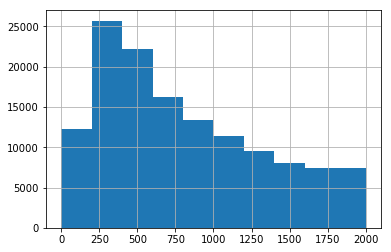

In [91]:
y_df[y_df['y_home_distance'] < 2000]['y_home_distance'].hist();

In [92]:
y_df['y_class'] = 0
y_df['y_class'][y_df['y_home_distance'] < 2 * LAT_001_DIST ] = 1
y_df['y_class'][y_df['y_work_distance'] < 2 * LAT_001_DIST ] = 2
y_df['y_class'][(y_df['y_home_distance'] < 2 * LAT_001_DIST) & (y_df['y_work_distance'] < 2 * LAT_001_DIST)] = 3

In [93]:
y_df.y_class.value_counts()

0    175271
1    107195
2     73520
3     33397
Name: y_class, dtype: int64

In [94]:
len(train_df), len(y_df)

(389383, 389383)